In [ ]:
# Unzip the upploaded data into Google Drive.
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision"

# 🐕End to End Multi class Dog Breed classification

This notebooks build an end-to-end multiclass Dog Breed Classifier using TensorFlow 2.0 and TensorHub

## 1. Problem
Identify the breed of the dog of a dog given an image of a dog.

## 2. Data
We are using data from Kaggle's dog breed identification completition

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set(these images do not have labels since we will be predicting that)

### Get your workspace ready

* Import TensorFlow 2.x ✅
* Import TensorFlow Hub✅
* Make sure we're using a GPU.

In [23]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF hub version: ", hub.__version__)

# Check for GPU avilability
print("GPU", "available (YESSS!!!!!!!!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version:  2.19.0
TF hub version:  0.16.1
GPU available (YESSS!!!!!!!!!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doign first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [24]:
# Checkout the lables of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: xlabel='breed'>

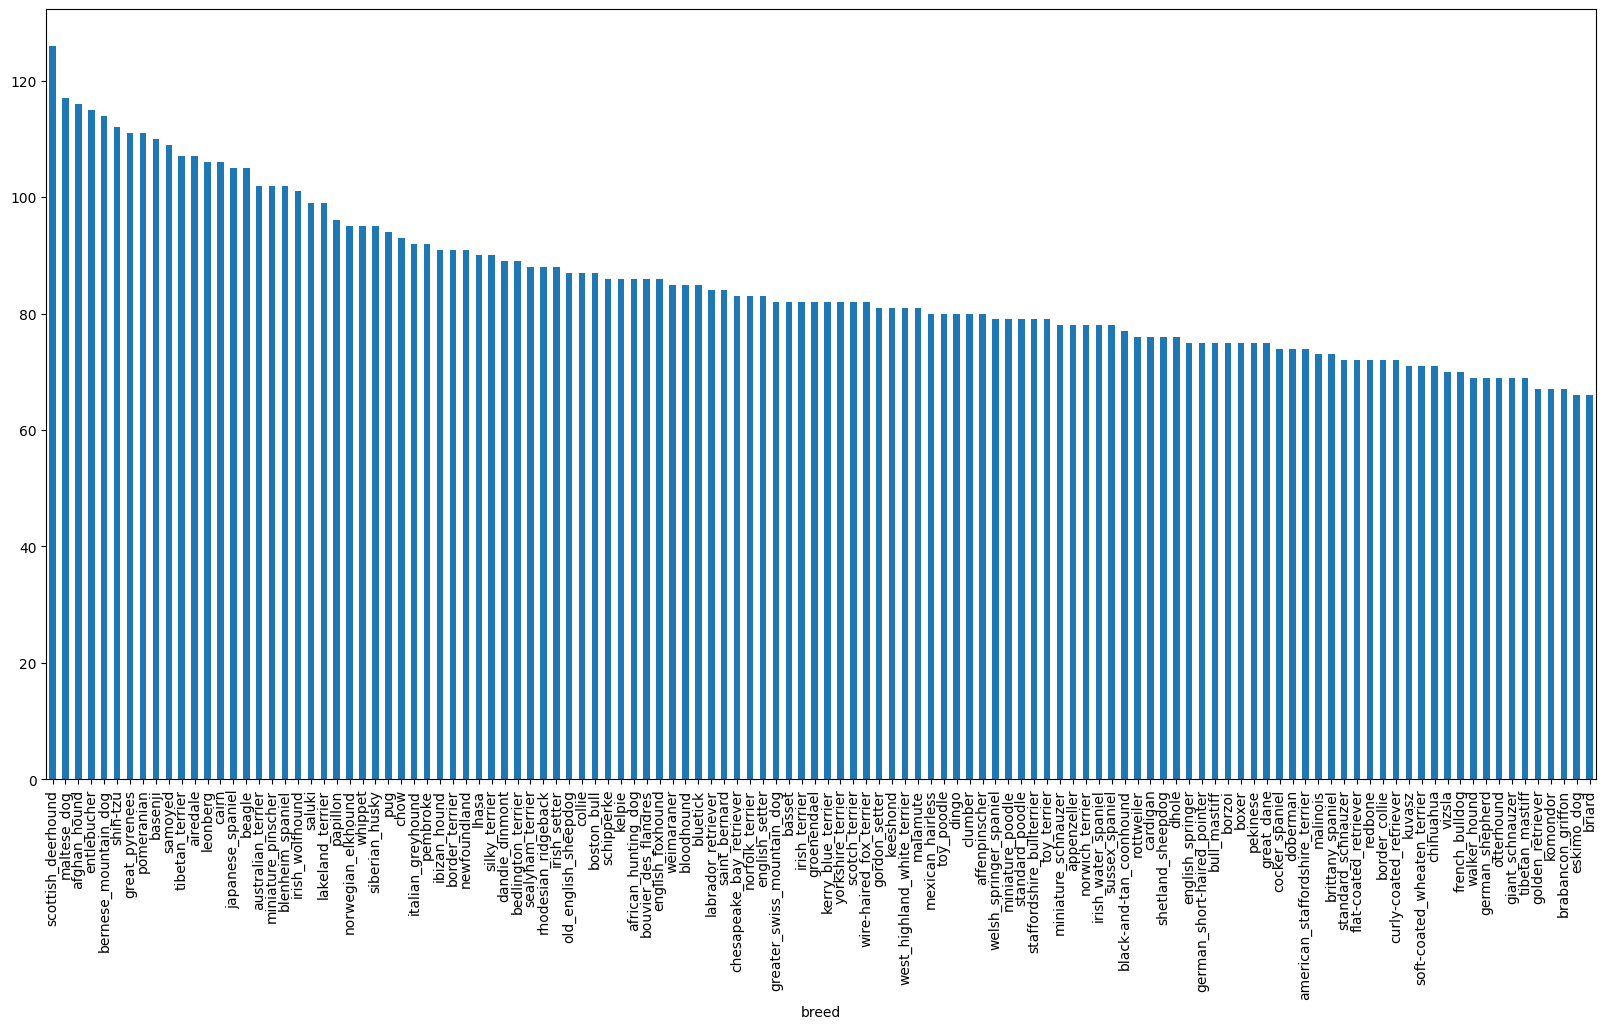

In [3]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [5]:
labels_csv["breed"].value_counts().median()
# To check if the data is distributed properly so we can create a model which is accurate in oredicting.

82.0

In [ ]:
labels_csv["id"][:100]

,id
0,000bec180eb18c7604dcecc8fe0dba07
1,001513dfcb2ffafc82cccf4d8bbaba97
2,001cdf01b096e06d78e9e5112d419397
3,00214f311d5d2247d5dfe4fe24b2303d
4,0021f9ceb3235effd7fcde7f7538ed62
...,...
95,024fc0be976885d5cfcf6770239a9001
96,024fd994941146f8dfdb38a9b2b74efd
97,02508e76981e1ba059d785704b4c480c
98,0255a5bca3b9d91d4fdba8d7419b5e69


In [25]:
file_names = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

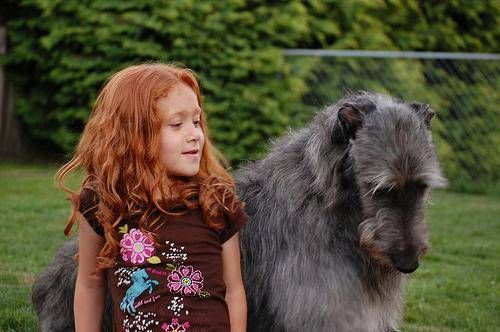

In [7]:
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg")

In [8]:
import os
if len(file_names) == len(os.listdir("drive/MyDrive/Dog Vision/train/")):
  print("Filenames match the images in the training set")
else:
  print("Mismatch in the data")

Filenames match the images in the training set


Since now we have images as filenames now we can convert labels into numbers

In [26]:
labels = labels_csv["breed"]

In [10]:
len(labels)

10222

In [11]:
# Finding unique breeds
import numpy as np
unique_breeds = np.unique(labels)
unique_breeds
len(unique_breeds)

120

Now we will create a list of lists for eac label with unique_breeds as a boolean list.

In [ ]:
# For a single label this is how the unique boolean breed list looks
print(labels[0] == unique_breeds)

[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


In [27]:
# We will go through all the labels and create a similar list for all of them
boolean_labels = [label == unique_breeds for label in labels]
print(boolean_labels[:2])
len(boolean_labels)

[array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False]), array([False, False, False, False, False, False, False, Fal

10222

In [13]:
print(boolean_labels[0].argmax()) # Index where the label occurs
print(boolean_labels[0].astype(int)) # Converting the list into integers.

19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


Now we have all the data set.  
There is one more thing missing, there is no validation set.  
As per convention it is better to have a validation set.


In [28]:
# Set X and y first
X = file_names
y = boolean_labels

There is around 10K data. We should not test on 10k data at once since it will take lot of time.So we start with 1k and then grdually increase.

In [29]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [30]:
# Split the data and create a validation set
from sklearn.model_selection import train_test_split

X_train,X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42
                                                  )
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocessing the Images (Turning images into Tensors)
To preprocess images into tensors we will have to follwo this steps
1. Take an image filepath as an input.
2. Use TensorFlow to load the image and save it in a variabe called `image`
3. Turn `image` into `tensors`
4. Normalise our image colors from (0,255) to (0,1)
5. Resize the `image`
6. Return the `image`

Before that lets see what importing an image looks like.

In [31]:
# Convert image into numpy array
from matplotlib.image import imread
image = imread(file_names[25])
image.shape

(375, 500, 3)

In [32]:
image.max(), image.min()

(np.uint8(255), np.uint8(0))

In [ ]:
image[:2]

array([[[153,  69,  85],
        [124,  50,  63],
        [120,  69,  76],
        ...,
        [220, 237, 245],
        [221, 238, 246],
        [222, 239, 247]],

       [[151,  64,  81],
        [131,  57,  70],
        [124,  71,  79],
        ...,
        [225, 242, 250],
        [226, 243, 251],
        [227, 244, 252]]], dtype=uint8)

In [ ]:
# Convert n image into tensors
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[153,  69,  85],
        [124,  50,  63],
        [120,  69,  76],
        ...,
        [220, 237, 245],
        [221, 238, 246],
        [222, 239, 247]],

       [[151,  64,  81],
        [131,  57,  70],
        [124,  71,  79],
        ...,
        [225, 242, 250],
        [226, 243, 251],
        [227, 244, 252]]], dtype=uint8)>

We will create a function to perforn all the steps mentioned in the above list.

In [42]:
IMG_SIZE = 224

def process_image(image_path):
  """
  Take an image file from the path and turn it into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical tensor with 3 Color channels (Red, Green, Blue)
  # Using tf.image.decode_jpeg for explicit JPEG decoding
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from (0,255) to (0,1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

### Turning our data into batches
Why turn our data into batches?  
Let's say you're trying to process 10,000+ images in one go... they all might not fit in memory.  
So that's why we d aabout 32 (this is the batch size) images at a time (You can manually adjust the batch size if need be).  
In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this (image, label).

In [43]:
# Create a simple function to return a tuple(image, label)
def get_image_label(image_path, label):
  """
  Takes and image file path and
  converts it into image tensor and label tuple.
  """
  image = process_image(image_path)
  return image, label

In [35]:
get_image_label(X[25], y[25])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.5307006 , 0.22634211, 0.27600926],
         [0.45544854, 0.31159487, 0.31144536],
         [0.6115267 , 0.5318722 , 0.51734024],
         ...,
         [0.91269314, 0.96854043, 0.99760914],
         [0.867437  , 0.9352942 , 0.9660715 ],
         [0.8669382 , 0.941448  , 0.96889895]],
 
        [[0.57807887, 0.26181412, 0.311874  ],
         [0.45787397, 0.30526328, 0.30887184],
         [0.4973039 , 0.4190161 , 0.40396008],
         ...,
         [0.9047149 , 0.95961684, 0.99855757],
         [0.8781888 , 0.9461202 , 0.976228  ],
         [0.89163107, 0.96614087, 0.9896703 ]],
 
        [[0.62315303, 0.28314835, 0.33458745],
         [0.4686783 , 0.2911783 , 0.2988918 ],
         [0.41489533, 0.33240825, 0.3146649 ],
         ...,
         [0.85797155, 0.90749884, 0.95806783],
         [0.8490338 , 0.92435944, 0.9466651 ],
         [0.8853643 , 0.96524876, 0.98071617]],
 
        ...,
 
        [[0.21191205, 0.18322672

Now we've got a way to turn our data into tuples of Tensors in the foem: (image, label).  
Lets make a function to turn all our data (X & y) into batches

In [44]:
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, test_data=False, valid_data=False):
  """
  Creates batches of data out of image(X) and labels(y)
  Shuffle the batches only for training not for validation or test set.
  Also except test_data as input (no labels)
  """
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("Creating valid data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [50]:
val_data = create_data_batches(X_val, y_val, valid_data=True)
train_data = create_data_batches(X_train, y_train)

Creating valid data batches...
Creating training data batches...


### Visualize the data
Since its hard to comprehend the batches we can visualize the batch data for that we will create a function.

In [46]:
import matplotlib.pyplot as plt
# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  """
  Display a plot of 25 images ad their labels from a data batch.
  """
  # Setup a figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

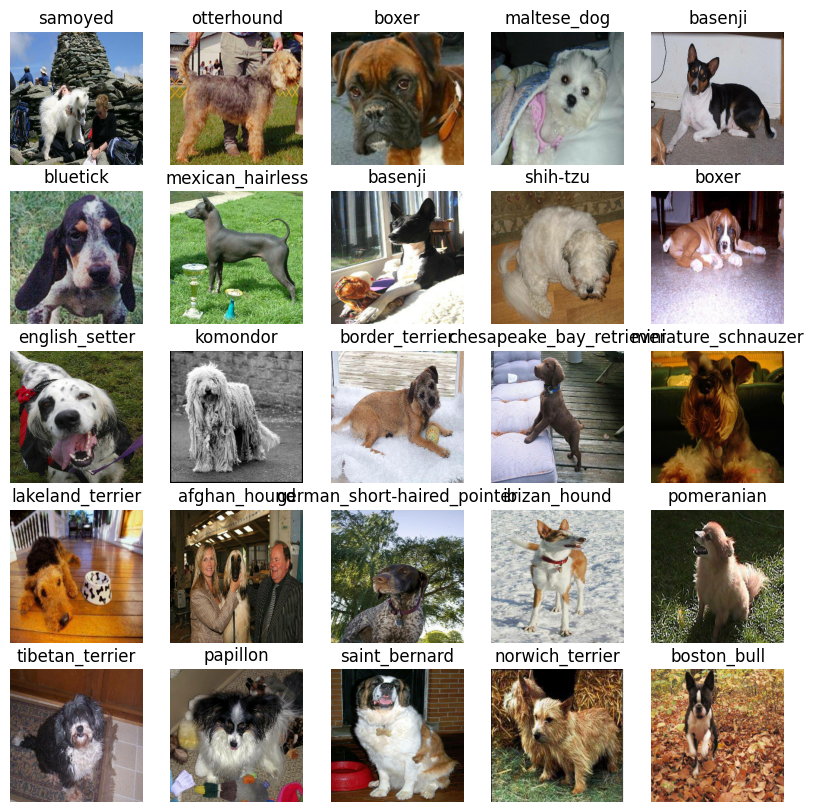

In [49]:
# Unbatching the batched images so they can be plotted
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

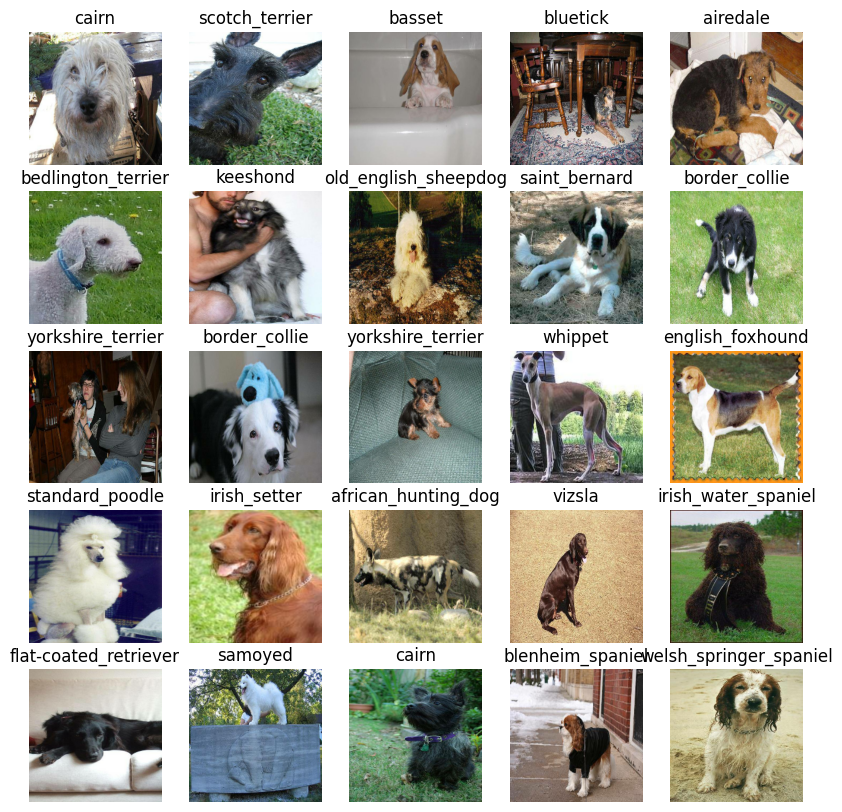

In [53]:
# Visualizing the validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a Model

Before we build a model, there are a few things we need to define.
1. The input shape(our image shape, in the form of Tensors) to our model.
2. The output shape (image labels, int he form of Tensors) of our model.
3. The URL of the model we want to use.

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = ...